# AutoKoopman Online System Identification

We summarize the work of Zhang et al. [[1]](#1) and connect it Koopman for Inputs and Control (KIC) [[2]](#2) for systems with inputs.

## Online Linear System Identification

We consider snapshot pairs $x_k, y_k$ where $y_k$ describes the dynamics of $x_k$ by the function $F$

$$
y_k = F(x_k).
$$

DMD learns F as a linear operator up until $k$ observations from the matrices

$$
\begin{aligned}
X_k = [x_1, x_2, ..., x_k] \\
Y_k = [y_1, y_2, ..., y_k]
\end{aligned}
$$

as 

$$
A_k = Y_k X_k^T \left(X_k X_k^T\right)^{-1}.
$$

The problem is given new observations $x_{k+1}, y_{k+1}$, a new operator $A_{k+1}$ must be *efficiently* derived from $A_k$. The following sections outline approaches more efficient that simply running DMD on $X_{k+1}, Y_{k+1}$ directly.



## Online DMD

DMD has the solution

$$
A_k = Y_k X_k^T \left(X_k X_k^T\right)^{-1}
$$

Grouping the matrics, we can assign
$$
\begin{aligned}
Q_k &= Y_k X_k^T \\
P_k &= \left(X_k X_k^T\right)^{-1}
\end{aligned}
$$

At the next time step, we can introduce the observations $x_{k+1}, y_{k+1}$,

$$
\begin{aligned}
Q_{k+1} = Y_k X_k^T + y_{k+1} x^T_{k+1} \\
P^{-1}_{k+1} = X_kX_k^T + x_{k+1} x_{k+1}^T
\end{aligned}
$$

Using the Sherman-Morrison formula,
$$
P_{k+1} = \left( P_k^{-1} + x_{k+1} x^T_{k+1}\right)^{-1} = P_k - \gamma_{k+1} P_k x_{k+1}x_{k+1}^T P_k
$$
where
$$
\gamma_{k+1} = \frac{1}{1 + x_{k+1}^T P_k x_{k+1}}
$$

## Online DMD with Inputs

We generalize online DMD to inputs like the Koopman for Input and Control (KIC) paper. We consider a new function $F: \mathcal Z \rightarrow \mathcal X$ that accepts state plus *input* $z \in \mathcal Z, z_k = [x_k | u_k]$. The inputs are not taken as dynamically evolving, so $F$ output only describes dynamics for the state. 

For inputs $x_k \in \mathbb R^n$ and $u_k \in \mathbb R^m$, $A \in \mathbb R^{n \times (n+m)}$, 

$$
A_k = Y_k Z_k^T (Z_k Z_k^T)^{-1}.
$$

The rest of the derivation follows as above.

## References

<a id="1">[1]</a>  Zhang, H., Rowley, C. W., Deem, E. A., & Cattafesta, L. N. (2019). Online dynamic mode decomposition for time-varying systems. SIAM Journal on Applied Dynamical Systems, 18(3), 1586-1609.

<a id="2">[2]</a>  Proctor, J. L., Brunton, S. L., & Kutz, J. N. (2018). Generalizing Koopman theory to allow for inputs and control. SIAM Journal on Applied Dynamical Systems, 17(1), 909-930.

In [1]:
import sys
sys.path.append("..")

import autokoopman.estimator.online_koopman as okoop
import autokoopman.core.observables as obs

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(20)

## Autonomous System Case

In [2]:
# initialize on short bursts
import autokoopman.benchmark.fhn as fhn
fhn = fhn.FitzHughNagumo()
training_data = fhn.solve_ivps(
    initial_states=np.random.uniform(low=-2.0, high=2.0, size=(1, 2)),
    tspan=[0.0, 10.0],
    sampling_period=0.1
)

In [3]:
# create an online estimator 
online = okoop.OnlineKoopmanEstimator(obs.IdentityObservable() | obs.RFFObservable(2, 25, 0.5), normalize=True)
online.initialize(training_data)

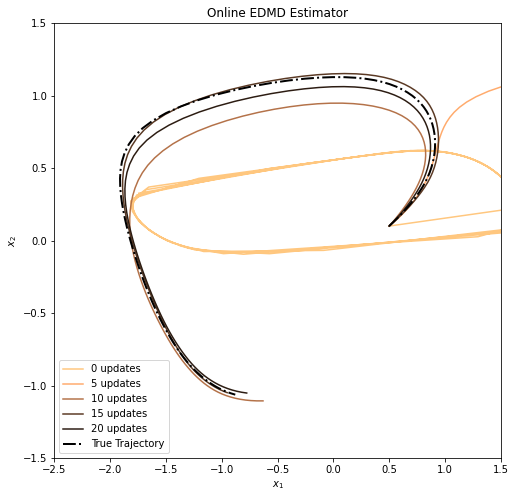

In [4]:
# simulate using the learned model
plt.figure(figsize=(8,8))
# get colors
num_colors = 21
cm = plt.get_cmap('copper')
colors_feature = [cm(1-i//3*3.0/num_colors) for i in range(num_colors)]

# test trajectory
def test_model(model):
    iv = [0.5, 0.1]
    return model.solve_ivp(
            initial_state=iv,
            tspan=(0.0, 10.0),
            sampling_period=0.1
        )

# plot as you update the streaming data
trajectory = test_model(online.model)
for idx in range(num_colors):
    if idx % 5 == 0:
        plt.plot(*trajectory.states.T, c=colors_feature[idx], label=f"{idx} updates")
    # new data
    streaming_data = fhn.solve_ivps(
        initial_states=np.random.uniform(low=-2.0, high=2.0, size=(1, 2)),
        tspan=[0.0, 1.0],
        sampling_period=0.1
    )
    # update the online estimator
    online.update(streaming_data)
    trajectory = test_model(online.model)

# simulate the ground truth for comparison
true_trajectory = test_model(fhn)

# plot the results
plt.plot(*true_trajectory.states.T, '-.k', linewidth=2.0, label="True Trajectory")
plt.xlim([-2.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.title("Online EDMD Estimator")
plt.show()

## Time-Invariant System Case


In [5]:
from autokoopman.benchmark.pendulum import PendulumWithInput

# create the pendulum system
pendulum_sys = PendulumWithInput(beta=0.05)

def make_input_step(duty, on_amplitude, off_amplitude, teval):
    """produce a step response input signal for the pendulum"""
    length = len(teval)
    on_amplitude *= 4.0
    on_amplitude -= 2.0
    off_amplitude *= 4.0
    off_amplitude -= 2.0
    inp = np.zeros((length,))
    phase_idx = int(length * duty)
    inp[:phase_idx] = on_amplitude
    inp[phase_idx:] = off_amplitude
    return inp

In [6]:
#  training data
teval = np.linspace(0, 3, 200)
dt = 10 / 200.0
params = np.random.rand(10, 3)
ivs = np.random.uniform(low=-1.0, high=1.0, size=(10, 2))
steps = [make_input_step(*p, teval) for p in params]
training_data = pendulum_sys.solve_ivps(ivs, inputs=steps, teval=teval)
test_inputs = np.atleast_2d(make_input_step(*np.random.rand(3), teval)).T

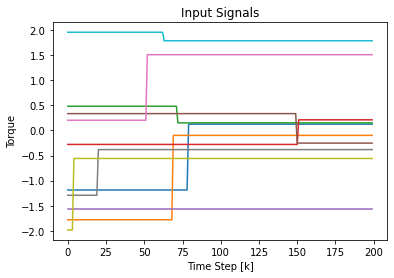

In [7]:
# plot the input signals
for ip in steps:
    plt.plot(ip)
plt.title("Input Signals")
plt.xlabel("Time Step [k]")
plt.ylabel("Torque")
plt.show()

In [8]:
# create an online estimator 
online = okoop.OnlineKoopmanEstimator(obs.IdentityObservable()| obs.RFFObservable(2, 25, 0.5), normalize=False)
online.initialize(training_data.interp_uniform_time(dt))

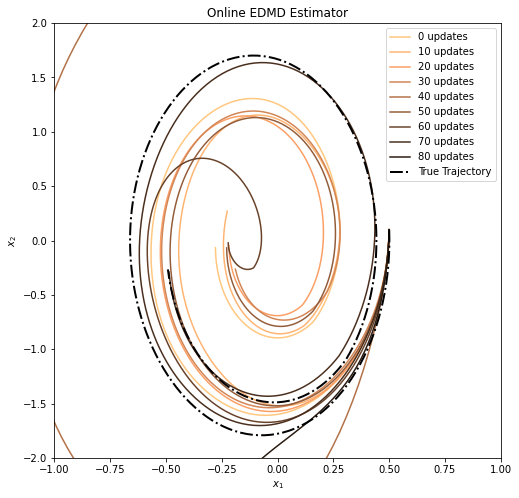

In [9]:
# simulate using the learned model
plt.figure(figsize=(8,8))
# get colors
num_colors = 90
cm = plt.get_cmap('copper')
colors_feature = [cm(1-i//3*3.0/num_colors) for i in range(num_colors)]

# test trajectory
def test_model(model):
    iv = [0.5, 0.1]
    return model.solve_ivp(
            initial_state=iv,
            teval=teval,
            inputs=test_inputs
        )

# plot as you update the streaming data
trajectory = test_model(online.model)
for idx in range(num_colors):
    if idx % 10 == 0:
        plt.plot(*trajectory.states.T, c=colors_feature[idx], label=f"{idx} updates")
    # new data
    streaming_data = pendulum_sys.solve_ivps(
        initial_states=np.random.uniform(low=-2.0, high=2.0, size=(1, 2)),
        teval=teval,
        inputs=[make_input_step(*p, teval) for p in np.random.rand(1, 3)]
    )
    # update the online estimator
    online.update(streaming_data.interp_uniform_time(dt))
    trajectory = test_model(online.model)

# simulate the ground truth for comparison
true_trajectory = test_model(pendulum_sys)

# plot the results
plt.plot(*true_trajectory.states.T, '-.k', linewidth=2.0, label="True Trajectory")
plt.xlim([-1, 1])
plt.ylim([-2, 2])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.title("Online EDMD Estimator")
plt.show()